# Quantstats Notebook
Get a quantstats tearsheet and insights on your strategies performance!

# Step 1: Get config and load the timeframe
Configure your paths accordingly

In [15]:
import json, os
from pathlib import Path

from freqtrade.configuration import Configuration
from freqtrade.data.btanalysis import load_trades_from_db, load_backtest_data, load_backtest_stats
from freqtrade.data.history import load_pair_history
from freqtrade.resolvers import StrategyResolver

import numpy as np
import pandas as pd

import quantstats as qs

configs=["config.json"]

ft_config = Configuration.from_files(files=configs)
ft_pairlists = PairListManager(ft_exchange, ft_config)
ft_dataprovider = DataProvider(ft_config, ft_exchange, ft_pairlists)

data_location = Path(ft_config['user_data_dir'], 'data', 'binance')
backtest_dir = Path(ft_config['user_data_dir'], 'backtest_results')

# Load strategy using values set above
strategy = StrategyResolver.load_strategy(ft_config)
strategy.dp = ft_dataprovider

# Generate buy/sell signals using strategy
timeframe = "5m"

backtest = False

if ft_config["timeframe"] is not None:
    timeframe = ft_config["timeframe"]
    print("Using config timeframe:" , timeframe)
elif strategy.timeframe is not None:
    timeframe = strategy.timeframe
    print("Using strategy timeframe:" , timeframe)
else:
    print("Using default timeframe:" , timeframe)


Using config timeframe: 5m


# Step 2: Load data and convert to a quantstats-readable Series

In [16]:
# Load Data
trades = load_backtest_data(backtest_dir)

daily_profit = trades.resample('1d', on='close_date')['profit_abs'].sum().round(5)
daily_profit = daily_profit.rename_axis("Date")

# Convert to date without timezone
t = daily_profit.axes[0]
t = t.tz_convert(None)
daily_profit = daily_profit.set_axis(t)

# Generate daily wallet value
value = ft_config['dry_run_wallet']
for d in daily_profit.iteritems():
    value = value + d[1]
    daily_profit.at[d[0]] = value


# Step 3: Do your analysis

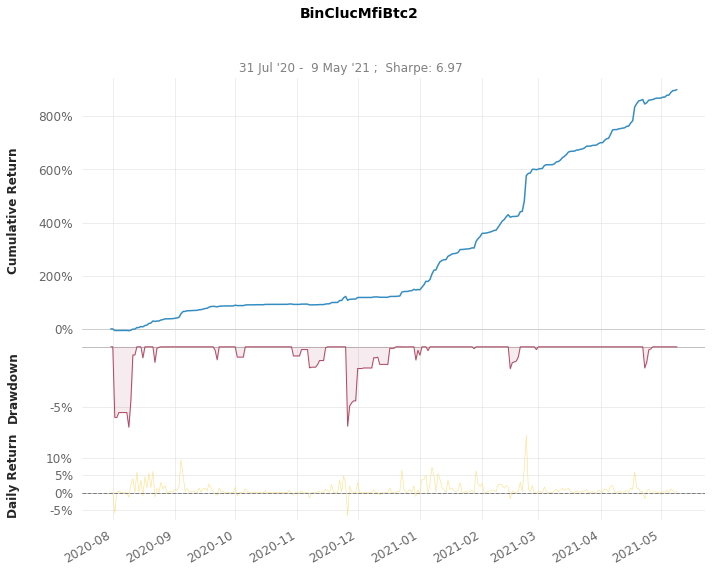

In [17]:
qs.plots.snapshot(daily_profit, title=ft_config['strategy'])

In [10]:
# Full Quantstats report file
qs.reports.html(daily_profit, title="Strategy analysis: " + ft_config['strategy'])